In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv(r"C:\Users\Asad shaikh\Documents\exchange_rate.csv", parse_dates=["date"], index_col="date")

# Ensure index is in datetime format
df.index = pd.to_datetime(df.index, format="%d-%m-%Y %H:%M", errors="coerce")

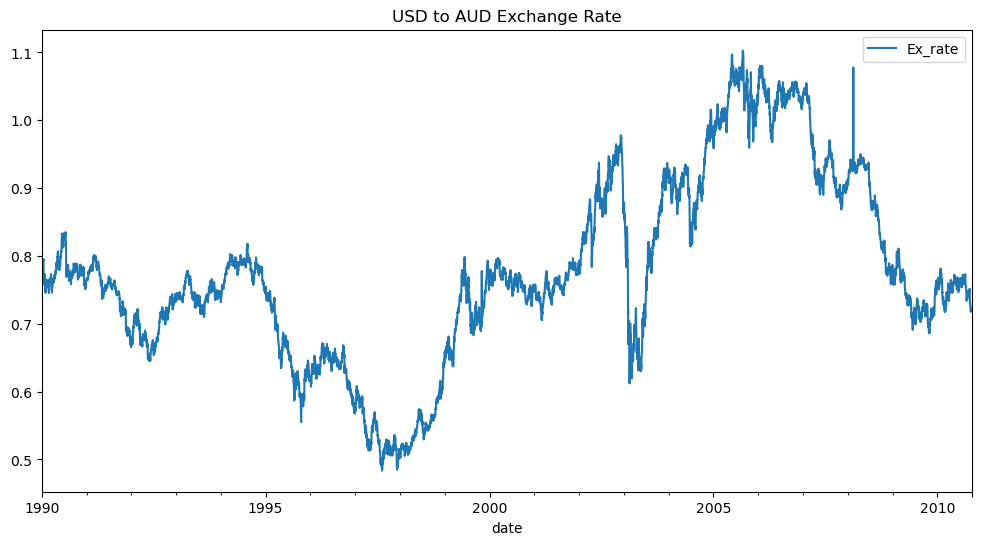

ADF Statistic: -1.6649941807381343, p-value: 0.44923273535979974
ADF Statistic (After Differencing): -99.39343120118627, p-value: 0.0


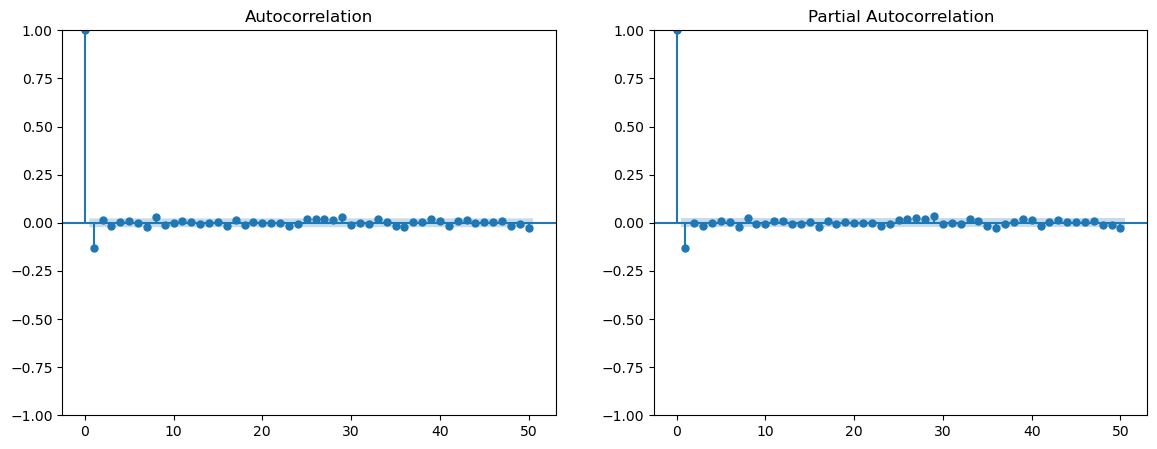

In [2]:
# Drop rows with NaT values in the index
df = df.dropna()

# Plot the time series
df.plot(figsize=(12, 6), title="USD to AUD Exchange Rate")
plt.show()

# Check stationarity using ADF test
adf_test = adfuller(df["Ex_rate"])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

# Differencing to make data stationary
df["Ex_rate_diff"] = df["Ex_rate"].diff()

# Recheck stationarity after differencing
adf_test_diff = adfuller(df["Ex_rate_diff"].dropna())
print(f"ADF Statistic (After Differencing): {adf_test_diff[0]}, p-value: {adf_test_diff[1]}")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df["Ex_rate_diff"].dropna(), ax=axes[0], lags=50)
plot_pacf(df["Ex_rate_diff"].dropna(), ax=axes[1], lags=50, method="ywm")
plt.show()

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 0)   Log Likelihood               28054.159
Date:                Wed, 12 Mar 2025   AIC                         -56104.319
Time:                        13:24:16   BIC                         -56090.450
Sample:                    01-01-1990   HQIC                        -56099.559
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -64.439      0.000      -0.135      -0.127
sigma2      3.595e-05   9.94e-08    361.720      0.000    3.58e-05    3.61e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

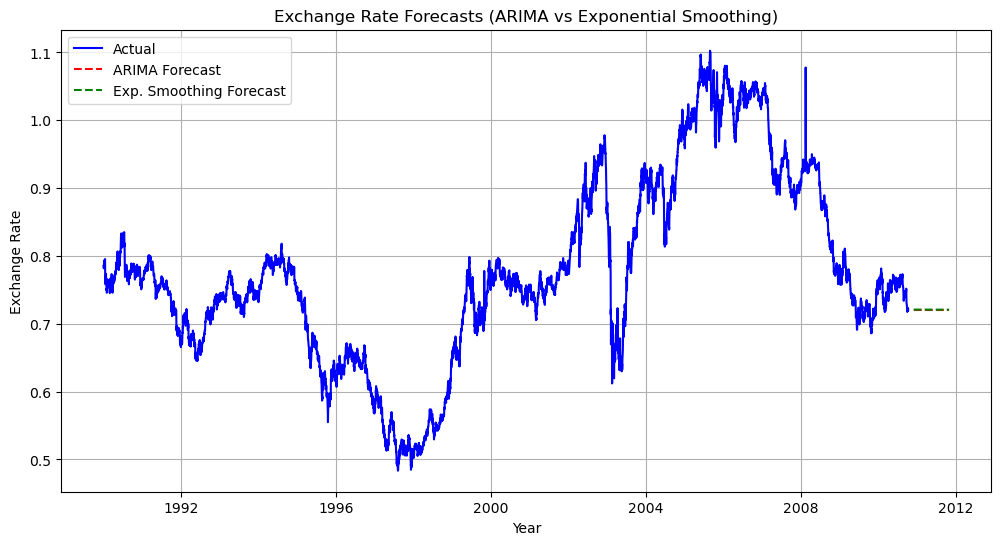

In [3]:
# Fit ARIMA(1,1,0)
arima_model = ARIMA(df["Ex_rate"], order=(1, 1, 0)).fit()
print(arima_model.summary())

# Forecast with ARIMA
forecast_steps = 12
arima_forecast = arima_model.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq="M")[1:]

# Fit Exponential Smoothing model
exp_model = ExponentialSmoothing(df["Ex_rate"], trend="add", seasonal=None).fit()
exp_forecast = exp_model.forecast(steps=forecast_steps)

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Ex_rate"], label="Actual", color="blue")
plt.plot(forecast_dates, arima_forecast, label="ARIMA Forecast", color="red", linestyle="dashed")
plt.plot(forecast_dates, exp_forecast, label="Exp. Smoothing Forecast", color="green", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.title("Exchange Rate Forecasts (ARIMA vs Exponential Smoothing)")
plt.legend()
plt.grid()
plt.show()



In [4]:
# Compute error metrics
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return mae, rmse

# Create test set (last 12 months for comparison)
test_set = df["Ex_rate"].iloc[-12:]

# Evaluate models
arima_mae, arima_rmse = evaluate_forecast(test_set, arima_forecast)
exp_mae, exp_rmse = evaluate_forecast(test_set, exp_forecast)

print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}")
print(f"Exponential Smoothing MAE: {exp_mae}, RMSE: {exp_rmse}")


ARIMA MAE: 0.0016640833333333345, RMSE: 0.0020001510984589835
Exponential Smoothing MAE: 0.0016726180265766166, RMSE: 0.001997199073838751
